<a href="https://colab.research.google.com/github/krec7748/Section_01_Project/blob/main/AI_05_%EA%B9%80%EB%8F%84%EC%9A%B1_Section_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Section 01 Project: 다음 분기에 어떤 게임을 설계해야 할까?>


In [1]:
#다음 분기에 출고량이 높을 것이라 예상되는 게임
#게임 설계를 "어떤 플랫폼"을 기반으로 "어떤 장르"로 해야 출고량이 높을지 분석

## 1. 전처리

In [2]:
import pandas as pd
import numpy as np

def int_to_year(num):
    this_year = 21 #2021년도
    if num < 0 or num == np.nan:
        return num.replace(num, np.nan)
    elif num < this_year:
        return int(num) + 2000
    elif num < 100:
        return int(num) + 1900
    else:
        return int(num)

def convert_str_to_number(string):
    if "K" in string:
        return float(string.replace("K", "")) * (10**3)
    elif "M" in string:
        return float(string.replace("M", "")) * (10**6)
    else:
        return float(string) * (10**6)

#csv파일 읽기
df = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv")
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

#데이터에서 결측치가 포함된 row제거 (361개, 전체 데이터의 약 2.71% 에 해당)
df.dropna(axis = 0, inplace = True) #결측치 제거

#출고량 데이터들을 수치형 데이터로 변환
df["Year"] = df["Year"].apply(int_to_year)
for Sales in ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]:
    df[Sales] = df[Sales].apply(convert_str_to_number)

#인덱스 reset
df.reset_index(drop = True, inplace = True)

#2017, 2020년 데이터들은 데이터수가 적어 신뢰성이 부족해 제거함.
del_index = df[(df["Year"] == 2017) | (df["Year"] == 2020)].index
df = df.drop(del_index) 

#지역별 출고량 합
df["All_Sales"] = df["NA_Sales"] + df["EU_Sales"] + df["JP_Sales"] + df["Other_Sales"]

#확인
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16237 entries, 0 to 16240
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16237 non-null  object 
 1   Platform     16237 non-null  object 
 2   Year         16237 non-null  int64  
 3   Genre        16237 non-null  object 
 4   Publisher    16237 non-null  object 
 5   NA_Sales     16237 non-null  float64
 6   EU_Sales     16237 non-null  float64
 7   JP_Sales     16237 non-null  float64
 8   Other_Sales  16237 non-null  float64
 9   All_Sales    16237 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.4+ MB


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000.0,0.0,0.0,0.0,40000.0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000.0,0.0,0.0,10000.0,180000.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.0,0.0,20000.0,0.0,20000.0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000.0,0.0,0.0,0.0,40000.0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000.0,90000.0,0.0,40000.0,250000.0
...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,150000.0,40000.0,0.0,10000.0,200000.0
16237,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,10000.0,0.0,0.0,0.0,10000.0
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,440000.0,190000.0,30000.0,130000.0,790000.0
16239,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,50000.0,50000.0,250000.0,30000.0,380000.0


## 2. 분석

### 1. "**지역**"과 "**선호하는 게임장르**"는 연관이 있을것인가?
= 위 물음에 답하기 위해 Chi-square test을 사용할 수 있음.

    (1) 귀무가설: 출고량에 대해 지역과 게임장르는 서로 연관이 없을 것이다. (독립적 O)
    (2) 대안가설: 출고량에 대해 지역과 게임장르는 서로 연관이 있을 것이다. (독립적 X)
    (3) 신뢰도: 95 %

In [3]:
df_Genre_sales = df.drop(["Name", "Platform", "Publisher", "All_Sales"], axis = 1, inplace = False)

df_Genre_sales.head()

,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,2008,Action,40000.0,0.0,0.0,0.0
1,2009,Action,170000.0,0.0,0.0,10000.0
2,2010,Adventure,0.0,0.0,20000.0,0.0
3,2010,Misc,40000.0,0.0,0.0,0.0
4,2010,Platform,120000.0,90000.0,0.0,40000.0


In [4]:
df_Year_Genre_Sales = df_Genre_sales.groupby(["Year", "Genre"]).sum()

df_Year_Genre_Sales2 = df_Year_Genre_Sales.reset_index(drop = False, inplace = False)

df_Year_Genre_Sales2.head()

,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1980,Action,320000.0,20000.0,0.0,0.0
1,1980,Fighting,720000.0,40000.0,0.0,10000.0
2,1980,Misc,2530000.0,150000.0,0.0,20000.0
3,1980,Shooter,6560000.0,430000.0,0.0,80000.0
4,1981,Action,13860000.0,810000.0,0.0,120000.0


In [5]:
#2 sample chi-square test (지역 - 장르의 연관성)
from scipy import stats

p_value_list = []
for i in range(1980, 2017, 1):
    sort = df_Year_Genre_Sales2.loc[df_Year_Genre_Sales2["Year"] == i]
    sort.index = sort["Genre"]
    sort_drop = sort.drop(["Year", "Genre"], axis = 1, inplace = False)
    for j in sort_drop.columns:
        if sort_drop[j].sum() == 0:
            sort_drop.drop([j], axis = 1, inplace = True)
    chi = stats.chi2_contingency(sort_drop, correction = False)
    pv = chi[1]
    p_value_list.append(pv)

df_p_value = pd.DataFrame(p_value_list, columns = ["p_value"])
df_p_value.index = range(1980, 2017, 1)
df_p_value.head()

,p_value
1980,0.0
1981,0.0
1982,0.0
1983,0.0
1984,0.0


In [6]:
 df_p_value.query("p_value < 0.05").shape[0] / df_p_value.shape[0]
 #모든 연도에서 귀무가설이 기각됨
 #출고량에 대해서 지역과 장르는 연관이 있다고 볼 수 있다.

1.0

In [7]:
#연관이 있다는 건 알았다. 이제 "어떤 지역"이 "어떤 장르"와 연관이 있는지 살펴보기 (2000년 이후)

#EDA
import matplotlib.pyplot as plt
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tan", "slateblue"]

Region_Genre = df.groupby(["Year", "Genre"]).sum()
for region in Region_Genre.columns:
    Region_Genre1 = Region_Genre.drop(["All_Sales"], axis = 1)

Region_Genre2 = Region_Genre1.reset_index(drop = False)
Region_Genre2

,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1980,Action,320000.0,20000.0,0.0,0.0
1,1980,Fighting,720000.0,40000.0,0.0,10000.0
2,1980,Misc,2530000.0,150000.0,0.0,20000.0
3,1980,Shooter,6560000.0,430000.0,0.0,80000.0
4,1981,Action,13860000.0,810000.0,0.0,120000.0
...,...,...,...,...,...,...
380,2016,Role-Playing,1390000.0,1290000.0,3630000.0,440000.0
381,2016,Shooter,7440000.0,7700000.0,610000.0,2420000.0
382,2016,Simulation,0.0,90000.0,300000.0,0.0
383,2016,Sports,4570000.0,7360000.0,780000.0,1920000.0


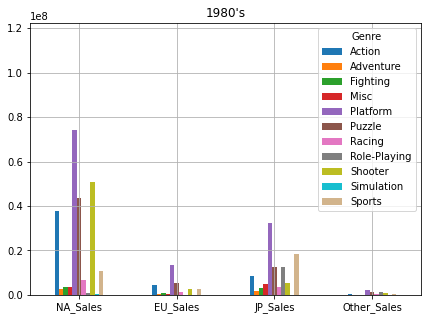

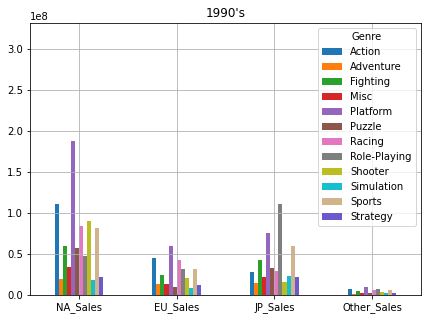

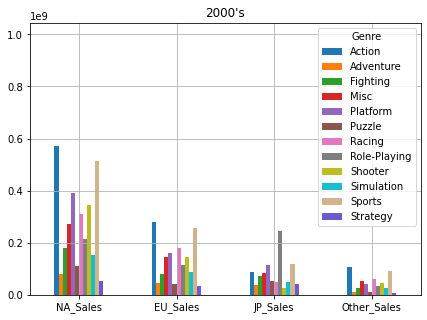

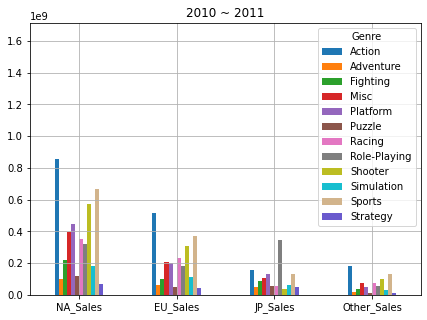

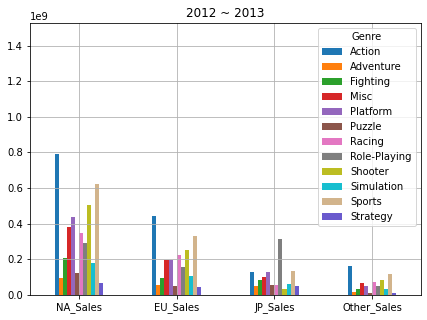

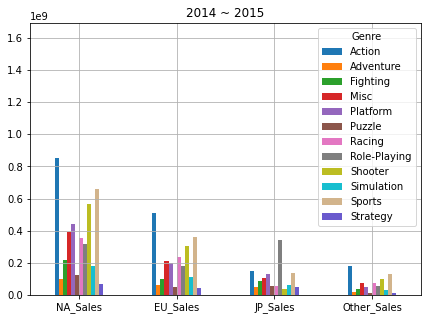

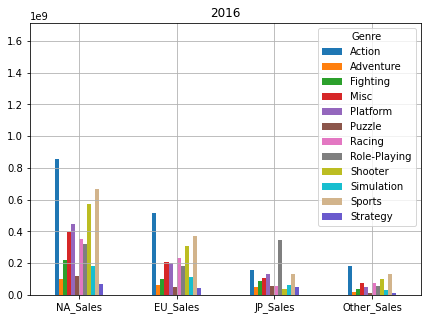

In [8]:
#연도별 지역과 장르의 출고량 시각화
#어떤 지역에서 어떤 장르가 선호도가 높은지 시각적으로 알 수 있을 것임.

i = 1980 #데이터에서 가장 작은 연도
Region_Genre3 = Region_Genre2.loc[Region_Genre2["Year"] < i + 10]
while i <= 2016: #데이터에서 가장 큰 연도
    Region_Genre3 = Region_Genre3.drop(["Year"], axis = 1)
    Region_Genre3 = Region_Genre3.groupby(["Genre"]).sum().T

    #시각화
    plt.rcParams["figure.figsize"] = (7,5) #크기
    Region_Genre3.plot(kind = 'bar', color = colors) #plot 유형, 색 지정
    plt.ylim(0, Region_Genre3.sum().max()) #y축 범위 지정
    plt.grid() #보조선
    plt.xticks(rotation = 0) # x-label 회전 각도
    #Title
    if i < 2010:
        plt.title("%d's"%i)
    elif i == 2016:
        plt.title("%d"%i)
    else:
        plt.title("%d ~ %d"%(i, i+1))
    
    plt.show()

    if i <= 2000:
        i += 10 #80연도에서 00연도 까지는 10년 단위로 묶어서 분석
        Region_Genre3 = Region_Genre2.loc[Region_Genre2["Year"] < i + 10]
    else:
        i += 2 #11년부터는 최신 데이터 이므로 2년 단위로 분석
        Region_Genre3 = Region_Genre2.loc[Region_Genre2["Year"] <= i + 1]

In [9]:
#결과 해석
#전반적으로 북미 + 유럽 시장이 전체 시장의 대부분을 차지한다는 것을 볼 수있다.

#80년대
# 북미: Platform, Shooter, Puzzle 순으로 선호도 높음.
# 유럽: Platform, Puzzle, Action 순으로 선호도 높음.
# 일본: Platform, Sports, Action 순으로 선호도 높음.

#90년대
# 북미: Platform, Action, Shooter 순으로 선호도 높음.
# 유럽: Puzzle, Action, Racing 순으로 선호도 높음.
# 일본: Role-playing, Platform, Sports 순으로 선호도 높음.

#00년대
# 북미: Action, Sports, Platform 순으로 선호도 높음.
# 유럽: Action, Sports, Racing 순으로 선호도 높음.
# 일본: Role-playing, Sports, Platform 순으로 선호도 높음.

#10 ~ 16년 (2년 단위로 나누어 분석했지만 지역별 동일한 선호도)
# 북미: Action, Sports, Shooter 순으로 선호도 높음.
# 유럽: Action, Sports, Shooter 순으로 선호도 높음.
# 일본: Role-playing, Action, Sports(= Platform) 순으로 선호도 높음.

#Other 시장은 전체 연도 통들어 차지하는 비율이 너무 작아 의미가 없다고 판단하여 해석에서 제외

### 2. 연도에 따른 장르별 시장점유율
- 연도별 게임의 트렌드를 알 수 있다.

In [10]:
#연도별 게임장르의 트렌드 분석

In [11]:
#필요없는 column 제거
df_year_sales = df.drop(["Name", "Platform", "Genre", "Publisher"], axis = 1, inplace = False)

#확인
df_year_sales.head()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
0,2008,40000.0,0.0,0.0,0.0,40000.0
1,2009,170000.0,0.0,0.0,10000.0,180000.0
2,2010,0.0,0.0,20000.0,0.0,20000.0
3,2010,40000.0,0.0,0.0,0.0,40000.0
4,2010,120000.0,90000.0,0.0,40000.0,250000.0


In [12]:
#지역별 출고량의 합을 연도별로 구하기
Year_Region_sum_list = []
for Sales in ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]:
    Year_sum = df_year_sales[Sales].groupby(df_year_sales["Year"]).sum()
    Year_Region_sum_list.append(Year_sum)

df_Year_Region_sum = pd.concat(Year_Region_sum_list, axis = 1)
df_Year_Region_sum["All_Sales"] = df_Year_Region_sum.sum(axis = 1)

df_Year_Region_All_Sales = df_Year_Region_sum["All_Sales"]
df_Year_Region_sum.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
Year,,,,,
1980,10130000.0,640000.0,0.0,110000.0,10880000.0
1981,33400000.0,1960000.0,0.0,320000.0,35680000.0
1982,26920000.0,1650000.0,0.0,310000.0,28880000.0
1983,7760000.0,800000.0,8100000.0,140000.0,16800000.0
1984,33280000.0,2100000.0,14270000.0,700000.0,50350000.0


In [13]:
#필요없는 column제거
df_Year_Genre = df.drop(["Name", "Platform", "Publisher", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"], axis = 1, inplace = False)

#확인
df_Year_Genre.head()

,Year,Genre,All_Sales
0,2008,Action,40000.0
1,2009,Action,180000.0
2,2010,Adventure,20000.0
3,2010,Misc,40000.0
4,2010,Platform,250000.0


In [14]:
#연도에 따른 장르별 시장점유율 구하기

#그룹화 (연도-장르, 지역별 출고량 합)
Year_Genre_sum = df_Year_Genre.groupby(["Year", "Genre"])["All_Sales"].sum()

#출고율 구해서 백분율로 변환
Year_Genre_ratio = Year_Genre_sum / df_Year_Region_All_Sales
df_Year_Genre_ratio = pd.DataFrame(Year_Genre_ratio)
df_Year_Genre_ratio = df_Year_Genre_ratio * 100 #백분율

#확인
df_Year_Genre_ratio

All_Sales
Year Genre                  
1980 Action         3.125000
     Fighting       7.077206
     Misc          24.816176
     Shooter       64.981618
1981 Action        41.451794
...                      ...
2016 Role-Playing   9.528515
     Shooter       25.649351
     Simulation     0.550536
     Sports        20.652174
     Strategy       0.734049

[385 rows x 1 columns]

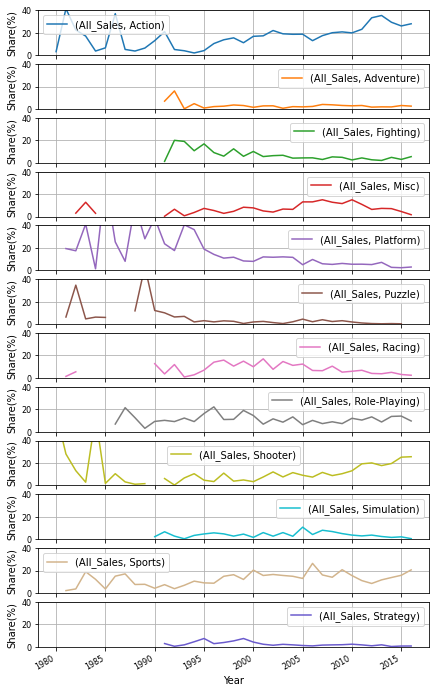

In [15]:
#연도에 따른 장르별 시장점유율 구하기 (시각화)
import matplotlib.pyplot as plt

#색 List
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tan", "slateblue"]

df_Year_Genre_ratio.unstack().plot(kind = 'line',
                                   fontsize = 8,
                                   figsize = (7, 13),
                                   color = colors,
                                   subplots = True,
                                   ylim = [0, 40],
                                   grid = True,
                                   xlabel = "Year",
                                   ylabel = "Share(%)")

plt.show()

In [16]:
#최근에는 Action, Shooter, Sports, Role-Playing이 게임 대부분의 장르를 차지하고 있음. (최근 대세 장르라고 해석이 가능함.)
#그러나 우리가 설계할 게임의 장르를 위 4가지로 결정하는 것은 섣부른 결정임. 
#특정 장르의 게임이 해당 년도에 출시한 게임수가 많으면 그 장르에 대한 출고량이 높은 게임이 많이 없어도 높은 점유율을 차지할 수도 있기 때문임.

#우리의 목적은 다음분기에 출고량이 높을거라고 예상되는 게임의 장르와 플랫폼을 결정하는 것임.

### 3. 출고량이 높은 게임에 대해 기준 설정 및 전처리
우리의 목적은 다음분기에 출고량이 높은것이라고 예상되는 게임의 장르와 플랫폼을 결정하는 것임

따라서 출고량이 높은 게임에 대해 분석을 할 필요가 있음. 그리고 그 전에 "출고량이 높다"에 대한 기준을 설정해야 하고 전처리 과정이 필요함.

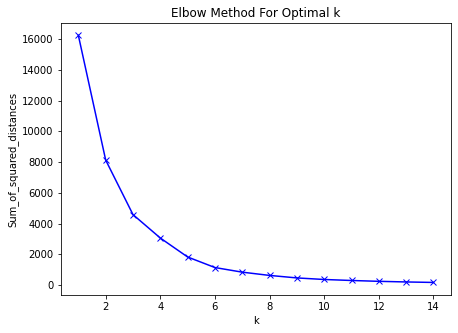

In [17]:
#높은 출고량에 대한 기준 설정에 K-means clustering을 이용할 것임.
#Elbow method를 이용해 적절한 K값을 결정

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_Total_Sales = df[["All_Sales"]]
scaler = StandardScaler()
df_Total_Sales_standard = scaler.fit_transform(df_Total_Sales)

sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(df_Total_Sales_standard)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show() #k값은 6

In [18]:
#표준화 및 K-means clustering 진행
import seaborn as sns

#지역별 출고량의 합에 대해서 표준화 진행 (Feature 1개)
scaler = StandardScaler()
All_Sales_std = scaler.fit_transform(df[["All_Sales"]])
df_All_Sales_std = pd.DataFrame(All_Sales_std, columns = ["std_All_Sales"])

#K-mean clustering
kmeans = KMeans(n_clusters = 6, random_state = 7)
kmeans.fit(df_All_Sales_std)
K_labels = kmeans.labels_
df_cluster = pd.DataFrame(K_labels, columns = ["Sale_rating"])

df["std_All_Sales"] = df_All_Sales_std["std_All_Sales"]
df["Sale_rating"] = df_cluster["Sale_rating"]

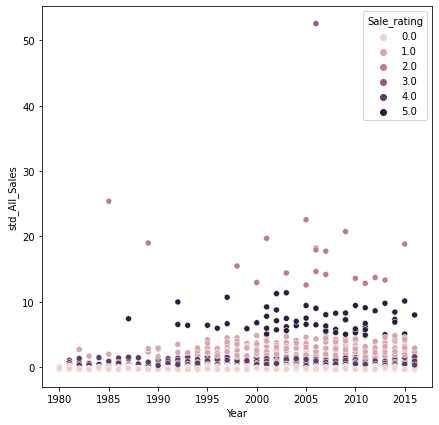

In [19]:
#K-means clustering 결과 이미지로 구현
plt.rcParams["figure.figsize"] = (7, 7)
#plt.rcParams["figure.figsize"] = (5, 200) #더 자세히 볼 수있음.
sns.scatterplot(x = "Year", y = "std_All_Sales", hue = "Sale_rating", data = df)

In [20]:
#결과에 따라 출고량이 높다고 판단되는 데이터만 선별 및 DataFrame화

#가장 작은 cluster를 제외한 나머지 5개의 cluster에 대해 출고량이 높다고 판단
df_Sales_high = df.query("Sale_rating > 0") #상위 14.34 %
df_Sales_low = df.query('Sale_rating == 0') #상위 85.43 %

#출고량이 높다는 기준 정의
rate = (df_Sales_high.shape[0] / (df.shape[0])) * 100
print("'높은 출고량'에 대한 기준은 결과적으로 상위", round(rate, 2), "% 입니다. \n")

#출고량이 높은 데이터 전처리
df_Sales_high.reset_index(drop = True, inplace = True)
df_Sales_high = df_Sales_high.drop(["Sale_rating", "std_All_Sales", "Name", "Publisher"], axis = 1, inplace = False)

#확인
df_Sales_high

'높은 출고량'에 대한 기준은 결과적으로 상위 14.34 % 입니다. 



,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
0,PS2,2002,Platform,570000.0,450000.0,0.0,150000.0,1170000.0
1,PS3,2013,Fighting,480000.0,530000.0,10000.0,230000.0,1250000.0
2,X360,2013,Shooter,510000.0,330000.0,10000.0,80000.0,930000.0
3,NES,1985,Puzzle,180000.0,0.0,850000.0,0.0,1030000.0
4,DS,2011,Platform,520000.0,60000.0,410000.0,50000.0,1040000.0
...,...,...,...,...,...,...,...,...
2323,PSV,2013,Role-Playing,160000.0,50000.0,120000.0,50000.0,380000.0
2324,GB,1999,Sports,0.0,0.0,170000.0,0.0,170000.0
2325,PS4,2016,Fighting,0.0,0.0,20000.0,0.0,20000.0
2326,GBA,2002,Platform,50000.0,20000.0,0.0,0.0,70000.0


### 4. 출고량이 높은 게임에 대한 분석 (플랫폼)

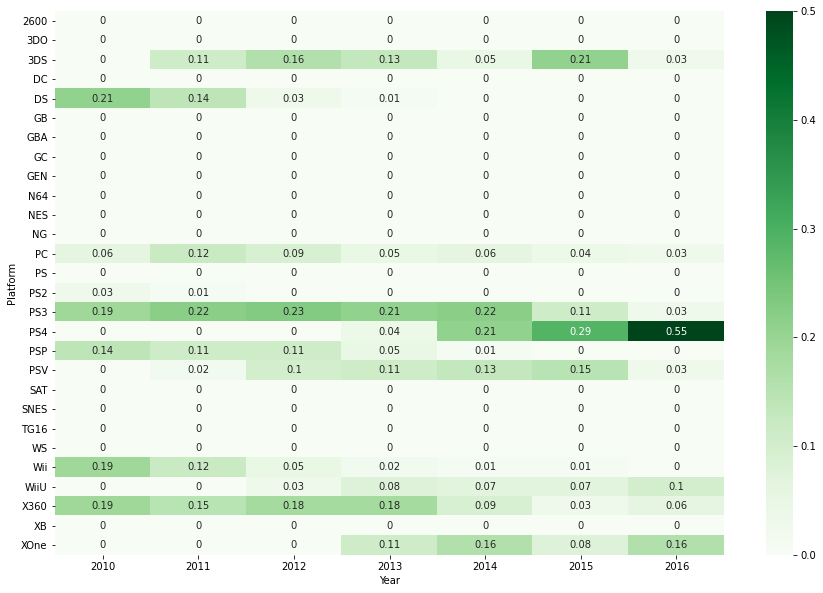

In [21]:
#출고량이 높은 게임들간의 점유율을 플랫폼별로 나타내기
#이 분석으로 최근에 시장이 선호하는 플랫폼을 알 수 있다.

import seaborn as sns

#출고량이 높은 게임들 간의 연도 - 플랫폼 별로 출시된 게임의 수를 DataFrame화
df_high_Year_Plat_count = pd.crosstab(df_Sales_high.Year, df_Sales_high.Platform, margins=True)

#필요없는 row제거
df_high_Year_Plat_count_drop = df_high_Year_Plat_count.drop(["All"], axis = 0)

#플랫폼별 점유율 계산하기 (출고량이 높은 게임들 사이에서)
for Plat in df_high_Year_Plat_count_drop.columns:
    df_high_Year_Plat_count_drop[Plat] = df_high_Year_Plat_count_drop[Plat] / df_high_Year_Plat_count_drop["All"]

#필요없는 column 제거
df_high_Year_Plat_count_drop2 = df_high_Year_Plat_count_drop.drop(["All"], axis = 1)

#소수점 자릿수 제어
df_high_Year_Plat_ratio = round(df_high_Year_Plat_count_drop2, 2).T

#2010년 이후 데이터만 추림.
df_high_Year_Plat_ratio_drop = df_high_Year_Plat_ratio.drop(df_high_Year_Plat_ratio.columns[:29], axis = 1)

#시각화
plt.rcParams["figure.figsize"] = (15, 10)
sns.heatmap(df_high_Year_Plat_ratio_drop,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = 0, vmax = 0.5 , #컬러차트 영역
           )

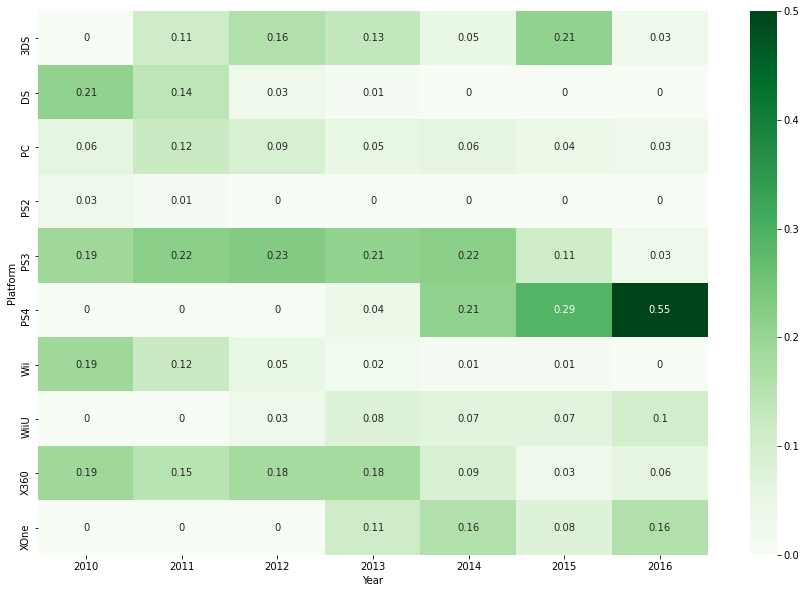

In [22]:
#주목하지 않아도 되는 platform제거 (다음분기에 설계할 게임의 플랫폼의 후보에서 제외)
df_high_Year_Plat_ratio_drop2 = df_high_Year_Plat_ratio_drop.drop(["2600", "3DO", "DC", "GB", "GBA", "GC",
                                                                   "GEN", "N64", "NES", "NG", "PS", "PSP",
                                                                   "PSV", "SAT", "SNES", "TG16", "WS", "XB"], axis = 0, inplace = False)

#다시 시각화
plt.rcParams["figure.figsize"] = (15, 10)
sns.heatmap(df_high_Year_Plat_ratio_drop2,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = 0, vmax = 0.5 , #컬러차트 영역
           )

plt.show()

In [23]:
#진한 Heatmap은 그 플랫폼이 현재 시장의 관심을 받고 있음을 뜻한다.
#최근에는 PS4, XOne, WiiU, X360 순으로 시장의 관심을 받고 있다고 해석할 수 있다.

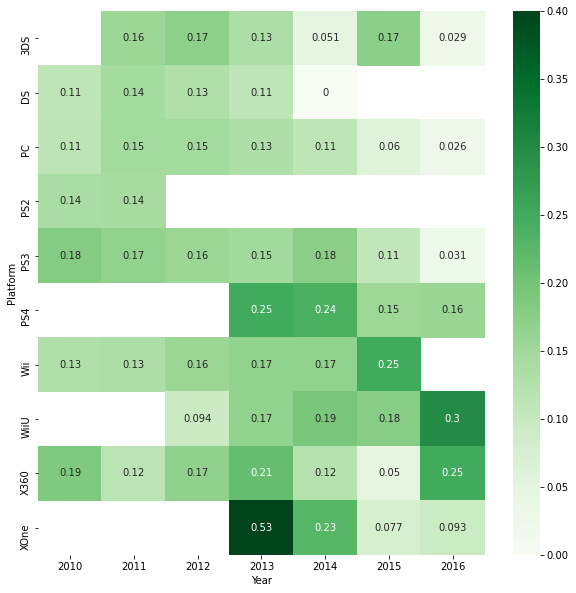

In [24]:
#출고량이 높은 게임이 전체시장에서 차지하는 비율을 플랫폼 별로 나타내기
#이 분석으로 특정 플랫폼을 출시했을 때 출고량이 높은 비중이 어느정도 차지하는지를 알 수 있음. (여러 요인이 있겠지만 출고량으로만 분석했을 때)

#출고량이 높은 게임들의 연도-플랫폼별 게임수와 전체 시장에서 연도-플랫폼별 게임수를 DataFrame화
df_high_Year_Plat_count = pd.crosstab(df_Sales_high.Year, df_Sales_high.Platform, margins=True)
df_Year_Plat_count = pd.crosstab(df.Year, df.Platform, margins=True)

#출고량이 높은 게임이 전체시장에서 차지하는 비율을 계산하기
df_high_Year_Plat_ratio_1 = df_high_Year_Plat_count / df_Year_Plat_count

#2010년 이후 데이터만 추림
df_high_Year_Plat_ratio2 = df_high_Year_Plat_ratio_1.T.drop(df_high_Year_Plat_ratio_1.T.columns[:30], axis = 1)

#필요없는 row, column 제거
df_high_Year_Plat_ratio2.drop(["All"], axis = 1, inplace = True)
df_high_Year_Plat_ratio2.drop(["All"], axis = 0, inplace = True)
df_high_Year_Plat_ratio2.drop(["2600", "3DO", "DC", "GB", "GBA", "GC",
                               "GEN", "N64", "NES", "NG", "PS", "PSP",
                               "PSV", "SAT", "SNES", "TG16", "WS", "XB", "GG", "PCFX", "SCD"],axis = 0, inplace = True)

#결측치 처리
df_high_Year_Plat_ratio2.fillna(0)

#시각화
plt.rcParams["figure.figsize"] = (10, 10)
sns.heatmap(df_high_Year_Plat_ratio2,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = 0, vmax = 0.4 , #컬러차트 영역
           )

In [25]:
#진한 heatmap은 그 플랫폼을 기반으로 한 게임을 출시했을 때 높은 출고량인 게임의 수가 많다는 것을 뜻함.
#WiiU, X360, PS4 순으로 해당 플랫폼을 기반으로 출시했을 때 높은 출고량인 게임의 수가 많다.

In [26]:
#그래서 어떤 플랫폼을 기반으로 하는 게임을 설계?
#종합해보면 압도적인 시장의 선호도를 가지는 PS4와 지금은 높은 출고량의 갖는 게임에 대한 점유율이 낮지만 유망있는 블루오션으로 보여지는 WiiU, X360, XONE 정도로 추릴 수 있겠다.
#요약: PS4, WiiU, X360, XONE순

### 5. 출고량이 높은 게임에 대한 분석 (장르)

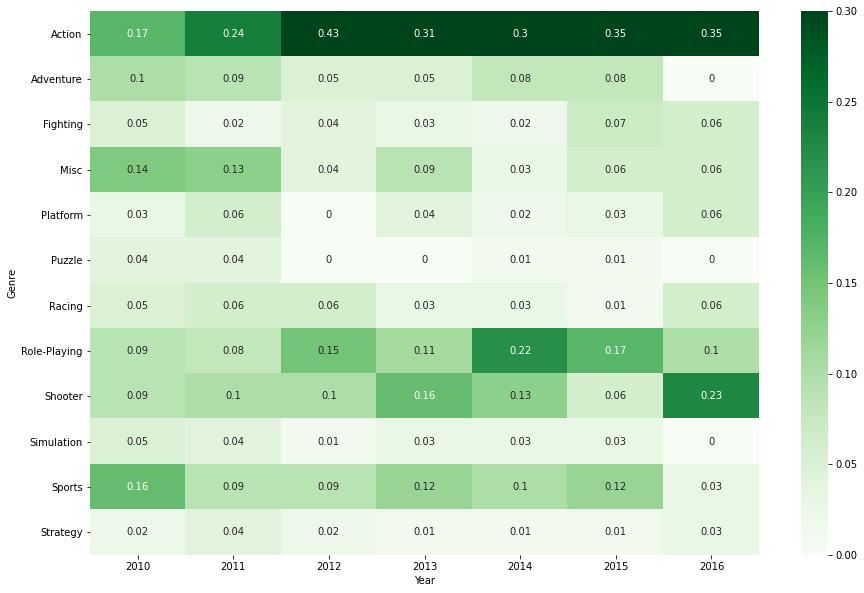

In [27]:
#출고량이 높은 게임들간의 점유율을 장르별로 나타내기
#이 분석으로 최근에 시장이 선호하는 장르를 알 수 있다.

import seaborn as sns

#출고량이 높은 게임들 간의 연도 - 장르별로 출시된 게임의 수를 DataFrame화
df_high_Year_Genre_count = pd.crosstab(df_Sales_high.Year, df_Sales_high.Genre, margins=True)

#필요없는 row제거
df_high_Year_Genre_count_drop = df_high_Year_Genre_count.drop(["All"], axis = 0)

#장르별 점유율 계산하기 (출고량이 높은 게임들 사이에서)
for Plat in df_high_Year_Genre_count_drop.columns:
    df_high_Year_Genre_count_drop[Plat] = df_high_Year_Genre_count_drop[Plat] / df_high_Year_Genre_count_drop["All"]

#필요없는 column 제거
df_high_Year_Genre_count_drop2 = df_high_Year_Genre_count_drop.drop(["All"], axis = 1)

#소수점 자리수 제어
df_high_Year_Genre_ratio = round(df_high_Year_Genre_count_drop2, 2).T

#2010년 이후 데이터만 추림
df_high_Year_Genre_ratio_drop = df_high_Year_Genre_ratio.drop(df_high_Year_Genre_ratio.columns[:29], axis = 1)

#시각화
plt.rcParams["figure.figsize"] = (15, 10)
sns.heatmap(df_high_Year_Genre_ratio_drop,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = 0, vmax = 0.3 , #컬러차트 영역
           )

In [28]:
#진한 Heatmap은 그 장르가 현재 시장의 관심을 받고 있음을 뜻한다.
#최근에는 Action, Shooter, Role-Playing 순으로 시장의 관심을 받고 있다고 해석할 수 있다.
#+ Sports의 경우 시장점유율은 높지만 높은 출고량을 갖는 게임이 별로 없는 것으로 보아 출시된 게임수는 많지만 다들 성적이 고만고만하다고 추측할 수 있다.(바다로 밑에서 할 분석에서 검증가능)

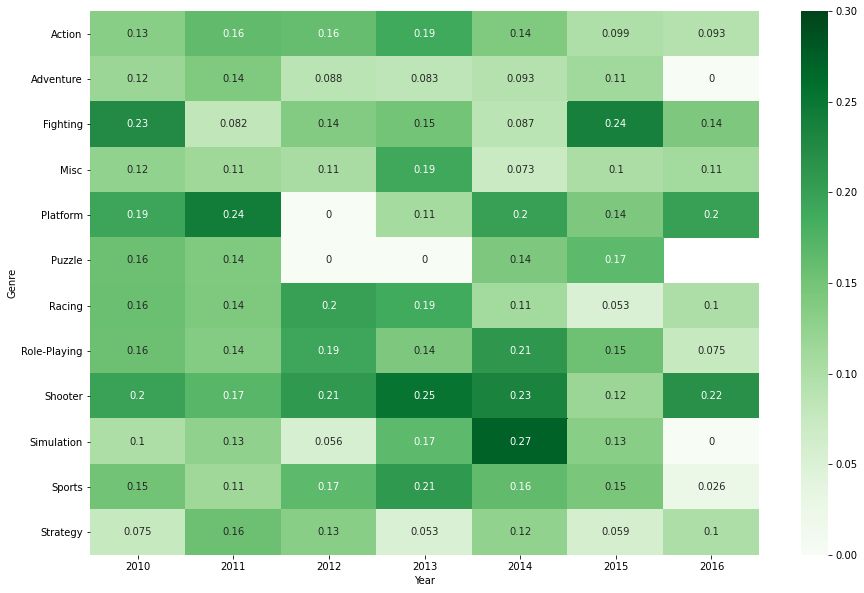

In [29]:
#출고량이 높은 게임이 전체시장에서 차지하는 비율을 장르별로 나타내기
#이 분석으로 특정 장르의 게임을 출시했을 때 출고량이 높은 비중이 어느정도 차지하는지를 알 수 있음. (여러 요인이 있겠지만 출고량으로만 분석했을 때)
#플랫폼이 아니기 때문에 이는 곧 그 장르에서의 경쟁률를 의미함. (낮을수록 경쟁률이 높음을 의미)
#그리고 위에서 분석한 시장의 장르를 결합해서 해석하면 해당 장르가 현재 레드오션인지, 블루오션인지, 유행하는지 알 수 있음.

#출고량이 높은 게임들의 연도-장르별 게임수와 전체 시장에서 연도-장르별 게임수를 DataFrame화 
df_Year_Genre_count = pd.crosstab(df.Year, df.Genre, margins=True)
df_high_Plat_Genre_count = pd.crosstab(df_Sales_high.Platform, df_Sales_high.Genre, margins=True)

#출고량이 높은 게임이 전체 시장에서 차지하는 비율을 계산하기
df_high_Year_Genre_ratio_1 = df_high_Year_Genre_count / df_Year_Genre_count

#2010년 이후 데이터만 추림
df_high_Year_Genre_ratio2 = df_high_Year_Genre_ratio_1.T.drop(df_high_Year_Genre_ratio_1.T.columns[:30], axis = 1)

#필요없는 row, column 제거
df_high_Year_Genre_ratio2.drop(["All"], axis = 1, inplace = True)
df_high_Year_Genre_ratio2.drop(["All"], axis = 0, inplace = True)

#결측치 처리
df_high_Year_Genre_ratio2.fillna(0)

#시각화
plt.rcParams["figure.figsize"] = (15, 10)
sns.heatmap(df_high_Year_Genre_ratio2,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = 0, vmax = 0.3 , #컬러차트 영역
           )

In [30]:
#Heatmap이 진할수록 경쟁률이 낮음을 뜻함.
#위에서 한 분석과 결합해 해석해보면 Action장르는 현재 레드오션, Shooter장르는 유행하며, Platform, fighting장르는 블루오션이라고 해석 할 수 있음.

In [31]:
#그래서 어떤 장르의 게임을 설계?
#종합해보면 최근 게임 장르 선호도도 어느정도 높으며 상승추세이고 아직 레드오션 구간에 진입하지 않은 Shooter 장르가 권장됨.
#요약: Shooter

### 6. 장르와 플랫폼의 연관성 고려
장르는 결정했지만 플랫폼은 아직이다.

장르(Shooter)가 어떤 플랫폼과 주로 연관이 있는지 알아볼 필요가 있다.

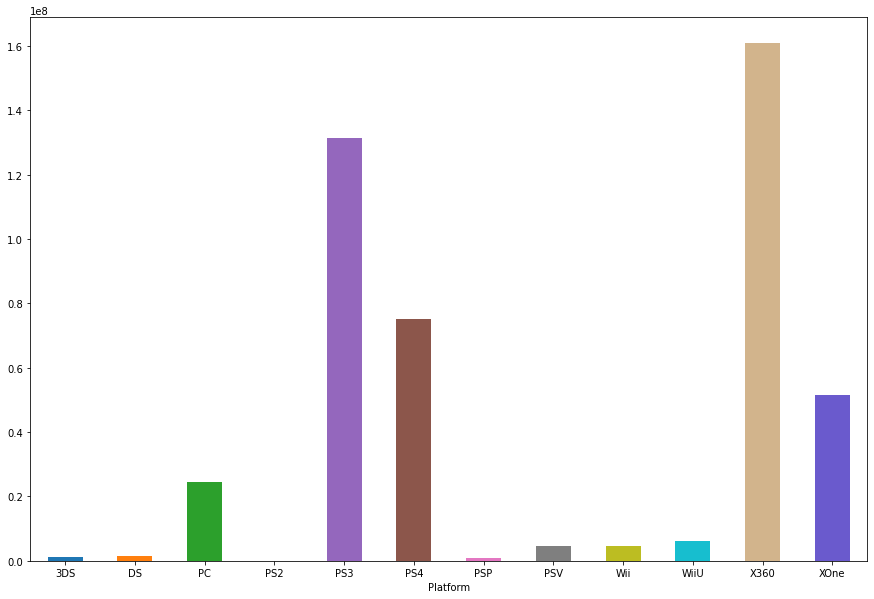

In [32]:
#Shooter장르 게임의 지역별 출고량합을 플랫폼 별로 나타내기 (2010년 이후)
Shooter = df.groupby(["Year","Genre", "Platform"]).sum()
df_Shooter = pd.DataFrame(Shooter.loc[2010:, "All_Sales"])
df_Shooter2 = df_Shooter.reset_index(level = 0, drop = True)
df_Shooter3 = df_Shooter2.loc[["Shooter"]]
df_Shooter4 = df_Shooter3.reset_index(drop = False)

df_Shooter_Plat = df_Shooter4.groupby(["Platform"])["All_Sales"].sum()

#시각화
df_Shooter_Plat.plot(kind = "bar", color = colors)
plt.xticks(rotation = 0)

plt.show()

In [33]:
#Shooter 장르는 PS3과 X360플랫폼에 특화된 것을 확인 할 수 있다.
#현재 PS3는 단종되었고, 앞서 선정한 플랫폼 후보군에도 있는 X360 플랫폼을 기반으로 출시하는게 권장된다.

#그리고 앞에서 분석한 자료를 이용해 최근 Shooter 장르의 지역별 출고량까지 종합한다면 북미와 유럽지역에서 출시할 것을 권장한다.

### 7. 결론
    지역: 북미, 유럽
    장르: Shooter
    플랫폼: X360